# 1. Введение
Целью данной задачи является обучение двх моделей классификации текстов для определения эмоций (**emotion**) на основе предложений (**sentence**). Для решения будут использованы простые методы мащинного обучения: **логистическую регрессию** и **наивный Байес**. Каждый этап выполнения будет прокомментирован.

# 2. Импорт библиотек

In [33]:
# Библиотеки для работы с данными и визуализации
import pandas as pd  # Для работы с табличными данными
import numpy as np   # Для числовых операций
import matplotlib.pyplot as plt  # Для построения графиков
import seaborn as sns  # Для улучшенной визуализации

# Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split  # Для разделения данных на тренировочную и тестовую выборки
from sklearn.feature_extraction.text import TfidfVectorizer  # Для векторизации текстовых данных через TF-IDF
from sklearn.linear_model import LogisticRegression  # Модель логистической регрессии
from sklearn.naive_bayes import MultinomialNB  # Модель наивного Байеса
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Для оценки качества модели

# Библиотеки для предобработки текста
import re  # Для работы с регулярными выражениями (удаление лишних символов)
import nltk  # Библиотека для обработки естественного языка
from nltk.corpus import stopwords  # Стоп-слова для удаления из текста
from nltk.stem import WordNetLemmatizer  # Лемматизатор для приведения слов к базовой форме

# 3. Загрузка и анализ данных

In [19]:
# Создание датасета из combined_emotions
df = pd.read_csv("C:\\archive\\combined_emotion.csv")
print('Первые 10 строк датасета:')
df.head(10)

Первые 10 строк датасета:


,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
5,i was beginning to feel quite disheartened,sad
6,i would think that whomever would be lucky eno...,love
7,i fear that they won t ever feel that deliciou...,joy
8,im forever taking some time out to have a lie ...,suprise
9,i can still lose the weight without feeling de...,sad


In [23]:
# Проверка размера датасета и распределения классов
print(f'Размер датасета: {len(df)}')
print('Распределение классов:')
df['emotion'].value_counts()

Размер датасета: 422746
Распределение классов:


emotion
joy        143067
sad        121187
anger       59317
fear        49649
love        34554
suprise     14972
Name: count, dtype: int64

In [27]:
# Проверка на наличие пропущенных значений 
print('Количество пропущенных значений:')
df.isnull().sum()

Количество пропущенных значений:


sentence    0
emotion     0
dtype: int64

**Комментарий**:  
На этом этапе мы проверили:
- Размер датасета
- Распределение классов (чтобы убедиться, что данные не сбалансированы - так и оказалось)
- Наличие пропущенных значений (пропущенных значений не обнаружилось)

# 4. Предобработка текста

In [37]:
# Скачиваем ресурсы NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\D1S3CT\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\D1S3CT\AppData\Roaming\nltk_data...


True

In [39]:
# Инизиализация лемматизаторов и списка стоп-слов 
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [67]:
def preprocess_text(text):
    # Приведение в нижний регистр, даже с учётом отсутствия верхнего регистра в текущем датасете
    text = text.lower()
    # Удаление пунктуации и специальных символов при помощи регулярных выражений
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #Разбиваем текст на отдельные слова при помощи метода split
    words = text.split()
    # Удаляем стоп-слова и лемматизируем используя списочное включение
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Объединяем слова обратно при помощи join
    return ' '.join(words)

In [71]:
# Применяем созданную функцию (предобработку) к данным, обработка такого количества данных может занять некоторое время
df['clean_sentence'] = df['sentence'].apply(preprocess_text)
print('Пример обработанного текста:')
df[['sentence', 'clean_sentence']].head()

Пример обработанного текста:


,sentence,clean_sentence
0,i just feel really helpless and heavy hearted,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,ive enjoyed able slouch relax unwind frankly n...
2,i gave up my internship with the dmrg and am f...,gave internship dmrg feeling distraught
3,i dont know i feel so lost,dont know feel lost
4,i am a kindergarten teacher and i am thoroughl...,kindergarten teacher thoroughly weary job take...


**Комментарий**:
- Преобразовали текст в нижний регистр, для случаев когда необходимо будет обработать предложения с верхним регистром
- Удалили лишние символы (в частности ненужную пунктуацию)
- Удалили стоп-слова (например 'i', 'am', 'and')
- Лемматизировали слова для уменьшения размерности признакового пространства (приведение слов к базовой форме)


# 5. Векторизация текста

In [83]:
# Инициализация TF-IDF векторизатора
vectorizer = TfidfVectorizer(max_features=5000) # Ограничиваем количество признаков
X = vectorizer.fit_transform(df['clean_sentence'])
y = df['emotion']

In [87]:
# Разделение на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Комментарий**  
Мы преобразовали тестовые данные в числовые признаки с помощью метода TF-IDF. Это позволяет использовать текстовые данные в алгоритмах МО

# 6. Обучение первой модели

In [93]:
# Обучение модели логистической регрессии
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [139]:
# Предсказание и оценка качества
y_pred1 = model1.predict(X_test)
print('Логистическая регрессия:')
print(classification_report(y_test, y_pred1))
print(f'Accuracy: {accuracy_score(y_test, y_pred1): .2f}')

Логистическая регрессия:
              precision    recall  f1-score   support

       anger       0.91      0.90      0.90     11810
        fear       0.86      0.86      0.86      9952
         joy       0.92      0.94      0.93     28781
        love       0.80      0.76      0.78      6929
         sad       0.94      0.94      0.94     24036
     suprise       0.79      0.71      0.75      3042

    accuracy                           0.90     84550
   macro avg       0.87      0.85      0.86     84550
weighted avg       0.90      0.90      0.90     84550

Accuracy:  0.90


**Комментарии**  
Логистическая регрессия была выбрана исходя из того, что это простой и быстрый алгоритм, часто показывающий хорошие результаты для текстовых данных. Исходя из результатов оценки, выбор оказался отличным. Исходя из полученных результатов первой модели можно сказать, что:
- Модель имеет высокую общую точность 0.90
- Лучше всего модель работает с классом 'sad', а сложнее всего ей даётся класс 'love' (f1-score=0.78) и 'suprise' (f1-score=0.75) из-за их меньшего количества
- В большинстве классов полнота и точность имеют баланс, кроме класса 'suprice', где полнота ниже 0.71 - это свидетельствует о том, что модель склонна часто пропускать этот класс

# 7. Обучение второй модели (Наивный Байес)

In [114]:
# Обучение модели наивного Байеса
model2 = MultinomialNB()
model2.fit(X_train, y_train)

MultinomialNB()

In [115]:
# Предсказание и оценка качества
y_pred2 = model2.predict(X_test)
print('Наивный Байес:')
print(classification_report(y_test, y_pred2))
print(f'Accuracy: {accuracy_score(y_test, y_pred2): .2f}')

Наивный Байес:
              precision    recall  f1-score   support

       anger       0.94      0.80      0.86     11810
        fear       0.89      0.74      0.81      9952
         joy       0.79      0.97      0.88     28781
        love       0.95      0.47      0.63      6929
         sad       0.86      0.95      0.90     24036
     suprise       0.96      0.32      0.48      3042

    accuracy                           0.85     84550
   macro avg       0.90      0.71      0.76     84550
weighted avg       0.86      0.85      0.84     84550

Accuracy:  0.85


**Комментарий**:
Наивный Байес так же был выбран из-за простоты реализации и его хорошей работы с дискретными данными, такими как частота слов. Подводя итоги о второй модели:
- Модель показала высокую точность для большинства классов (в особенности suprice 0.96)
- 'love' и 'suprice' имеют очень низкую полноту, модель часто пропускает данные два класса
- Общая точность наивного Байеса составила 0.85, что хуже, чем у логистической регрессиии (0.90) из-за чувствительности данного алгоритма к дисбалансу классов.

# 8. Анализ результатов

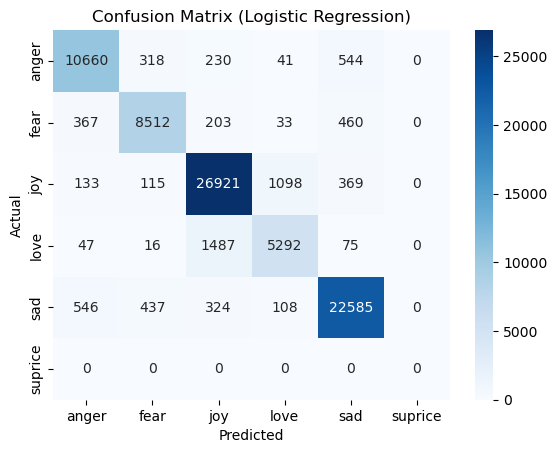

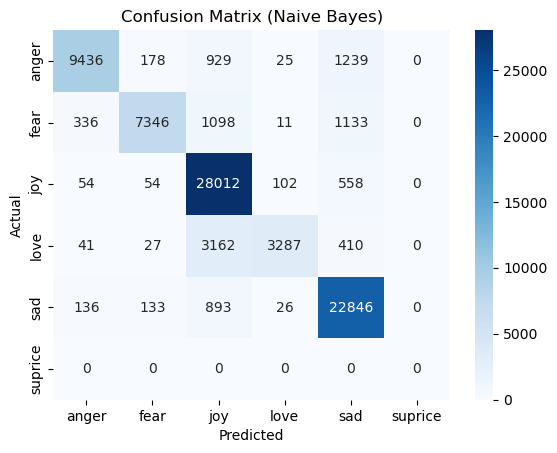

In [126]:
# Визаулизация матрицы путаницы для обеих моделей
def plot_confusion_matrix(y_true, y_pred, title, labels):
    # Создание матрицы путаницы
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Построение heatmap с названиями классов
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Настройка заголовка осей
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Список названий классов
class_labels = ['anger', 'fear', 'joy', 'love', 'sad', 'suprice']

# Построение матрицы путаницы
plot_confusion_matrix(y_test, y_pred1, 'Confusion Matrix (Logistic Regression)', class_labels)
plot_confusion_matrix(y_test, y_pred2, 'Confusion Matrix (Naive Bayes)', class_labels)

**Комментарий**: 
Данная матрица позволяет понять какие классы модель чаще путает и где она наиболее точна (может потребоваться для дальнейшей доработки модели)

# 9. Выводы

In [130]:
#Сравнение результатов
print('Сравнение результатов двух моделей:')
print(f'Accuracy (Logistic Regression): {accuracy_score(y_test, y_pred1):.2f}')
print(f'Accuracy (Naive Bayes): {accuracy_score(y_test, y_pred2):.2f}')

Сравнение результатов двух моделей:
Accuracy (Logistic Regression): 0.90
Accuracy (Naive Bayes): 0.85


In [134]:
# Финальные вывводы
if accuracy_score(y_test, y_pred1) > accuracy_score(y_test, y_pred2):
    print('Логистическая регрессия показала лучший результат')
else:
    print('Наивный Байес показал лучший результат')

Логистическая регрессия показала лучший результат


## Подводя итоги: 
#### Общая точность (Accuracy):
- Логистическая регрессия достигла точности = 0.90, в то время как Наивный Байес показал точность = 0.85.
- Это говорит о том, что логистическая регрессия более точно классифицирует примеры во всём датасете.
#### Сбалансированность метрик:
- Логистическая регрессия демонстрировала более сбалансированные значения точности, полноты и f1-score (баланс между точностью и полнотой) для большинства классов.
- Например, для класса "love" логистическая регрессия показала значительно лучшую полноту (0.76 против 0.47 у Наивного Байеса).
#### Учёт зависимостей между признаками:
- Логистическая регрессия не делает предположения о независимости признаков, в отличие от Наивного Байеса.
- В текстовых данных слова часто зависят друг от друга, что позволяет логистической регрессии лучше моделировать взаимосвязи между словами.
#### Работа с малыми классами:
- Хотя добавление данных для малых классов (например, "love" и "suprise") могло бы улучшить результаты Наивного Байеса, логистическая регрессия всё равно показала более стабильные результаты для этих классов.
- Например, для класса "suprise" логистическая регрессия имела более высокую полнотоу (0.71 против 0.32 у Наивного Байеса).
